In [1]:
import numpy as np
import os
import pandas as pd
import sys
import glob
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
from copy import deepcopy as dcopy
import pickle
import pandas as pd

In [2]:
# Hopefully long enough default list of colors:
tab20 = list(mpl.cm.get_cmap('tab20').colors)
tab20b = list(mpl.cm.get_cmap('tab20b').colors)
COLORS = tab20[ : : 2] + tab20[1 : : 2] + tab20b  # 40 colors
COLORS = COLORS * 10  # 400 colors

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [4]:
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

In [5]:
from IPython.display import IFrame
# %matplotlib notebook
%matplotlib widget
%config Completer.use_jedi = False

In [6]:
sys.path.append('..')
import cogwheel
from cogwheel import postprocessing, sampling, posterior, prior, gw_prior, utils, data
from cogwheel import cosmology as cosmo
from cogwheel import _private_ias
from cogwheel import grid as gd

In [7]:
import _private_scratch
from _private_scratch import analysis_handle as ahand
from _private_scratch import parameter_aliasing as aliasing
from _private_scratch import parameter_label_formatting as labform
from _private_scratch import pe_plotting as cwplot
from _private_scratch import standard_intrinsic_transformations as pxform

In [8]:
evname = 'GW151226'
parentdir = '/data/srolsen/GW/O1/PE/'  # Set to a path to save output
approximant = 'IMRPhenomXPHM'  # See cogwheel.waveform.APPROXIMANTS for options
prior_class = 'IASPrior'  # See `cogwheel.prior.prior_registry` for options

IAS Prior Runs

In [9]:
evdir = utils.get_eventdir(parentdir, prior_class, evname)

# example of highest-resolution GW151226 PE
#pe = ahand.AnalysisHandle(os.path.join(evdir, 'run_0'), name=r'\textsc{Default}')
pe = ahand.AnalysisHandle(os.path.join(evdir, 'run_0'), name=r"""\textsc{Default \\[15pt]  (Flat-in-$\chi_{\rm eff}$ Prior)}""")
pe_noHM = ahand.AnalysisHandle(os.path.join(evdir, 'run_0_noHM'), name='noHM, IAS Prior, n_live_points=20000, tol=.1')
pe_noPrec = ahand.AnalysisHandle(os.path.join(evdir, 'run_0_noPrec'), name='noPrec, IAS Prior, n_live_points=20000, tol=.1')

# this will add source parameters and basic intrinsic parameters, set flag to add more
pe.complete_samples(antenna=False, cosmo_weights=False, ligo_angles=False)
pe_noHM.complete_samples(antenna=False, cosmo_weights=False, ligo_angles=False)
pe_noPrec.complete_samples(antenna=False, cosmo_weights=False, ligo_angles=False)

LVC Prior Runs

In [10]:
evdir_lvc = utils.get_eventdir(parentdir, 'LVCPrior', evname)
pe_lvc = ahand.AnalysisHandle(os.path.join(evdir_lvc, 'run_0'), name='LVC Prior, n_live_points=20000, tol=.1')

pe_lvc.complete_samples(antenna=False, cosmo_weights=False, ligo_angles=False)

Collect prior samples

In [11]:
prior_dirs = ['/data/hschia/GW/gw_pe/precessing_flatchieff_HM/GW151226_prior',
           '/data/hschia/GW/gw_pe/precessing_isotropic_HM/GW151226_prior']

In [12]:
ias_prior_samples = pd.read_pickle(os.path.join(prior_dirs[0], 'ParameterEstimationPrecessingSpins_GW151226_samples.pkl'))
lvc_prior_samples = pd.read_pickle(os.path.join(prior_dirs[1], 'ParameterEstimationPrecessingSpinsLVCPrior_GW151226_samples.pkl'))

In [13]:
def summary(samples, frac_low=0.05, frac_high=0.95):
    print(samples.name)
    median = samples.median()
    quantile_005 = samples.quantile(q=frac_low)
    quantile_095 = samples.quantile(q=frac_high)
    print(f'median: {median:.2f},\n0.05 quantile: {quantile_005-median:.2f},\n0.95 quantile: {quantile_095-median:.2f}\n')

## Main PE Plot

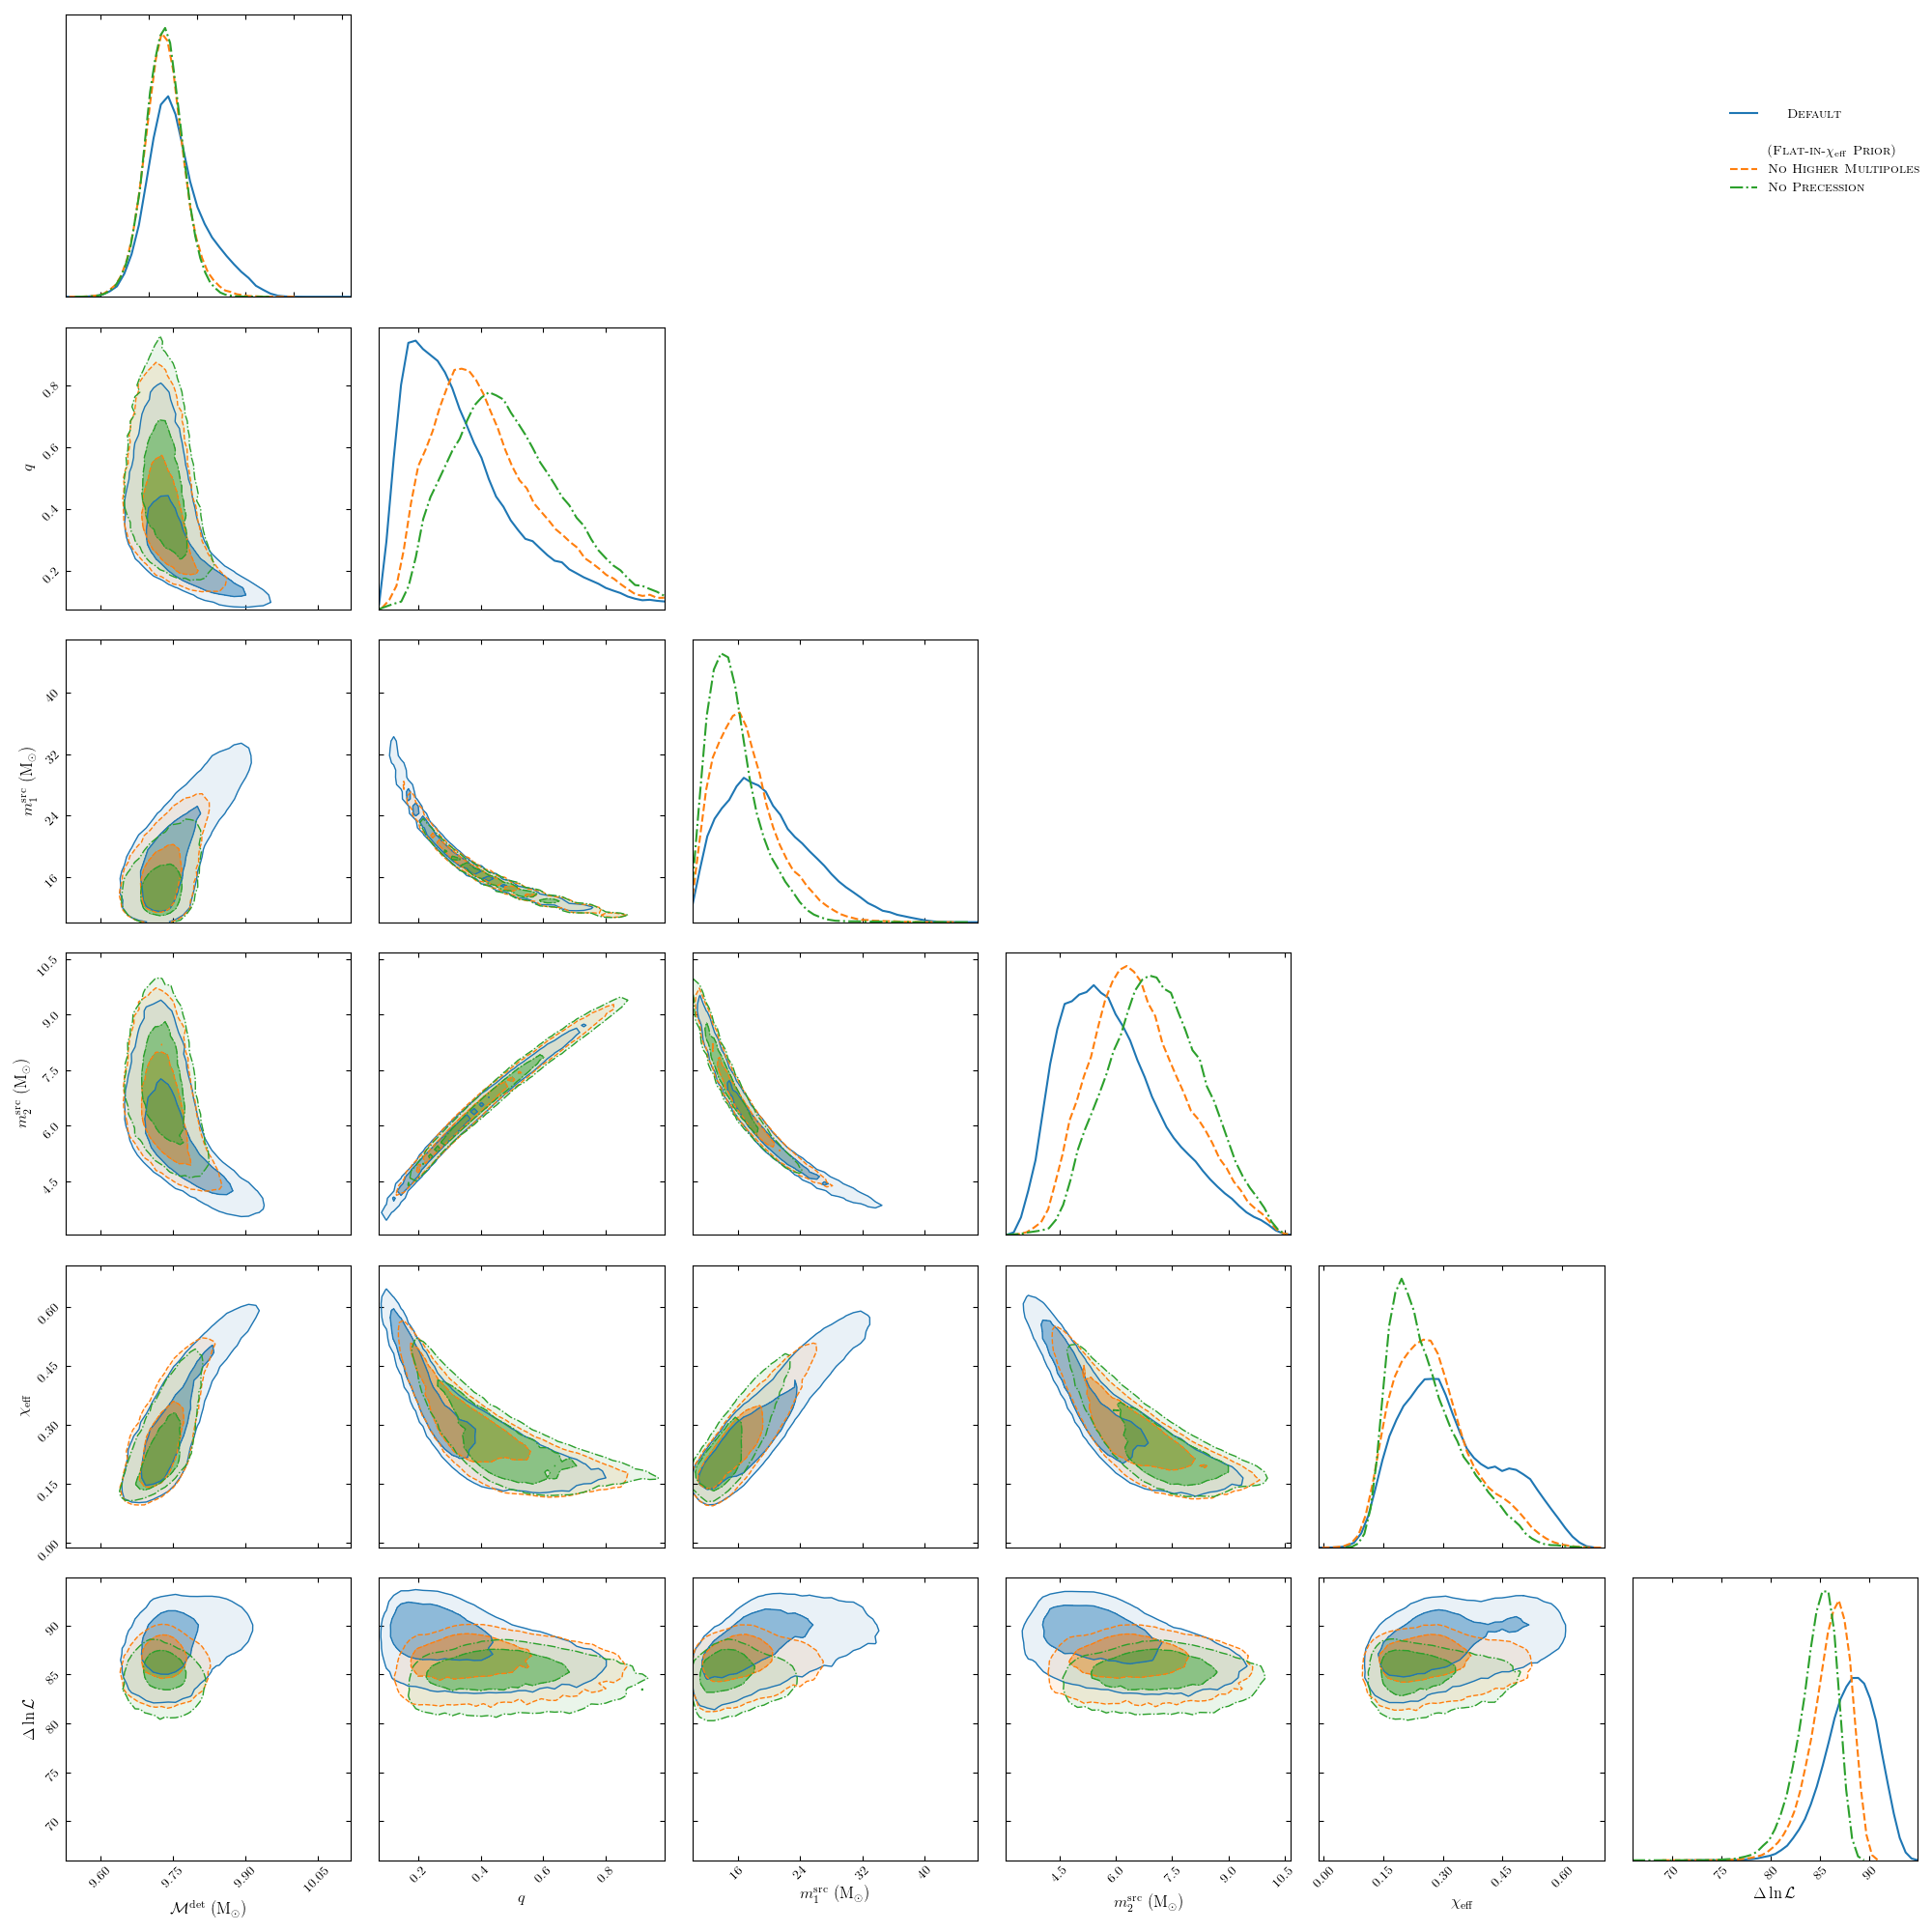

In [15]:
fig, ax = pe.corner_plot_comparison([pe_noHM, pe_noPrec], [r'\textsc{No Higher Multipoles}', r'\textsc{No Precession}'],
                                              ['mchirp', 'q', 'm1_source', 'm2_source', 'chieff', 'lnl'], figsize=(20,20),)

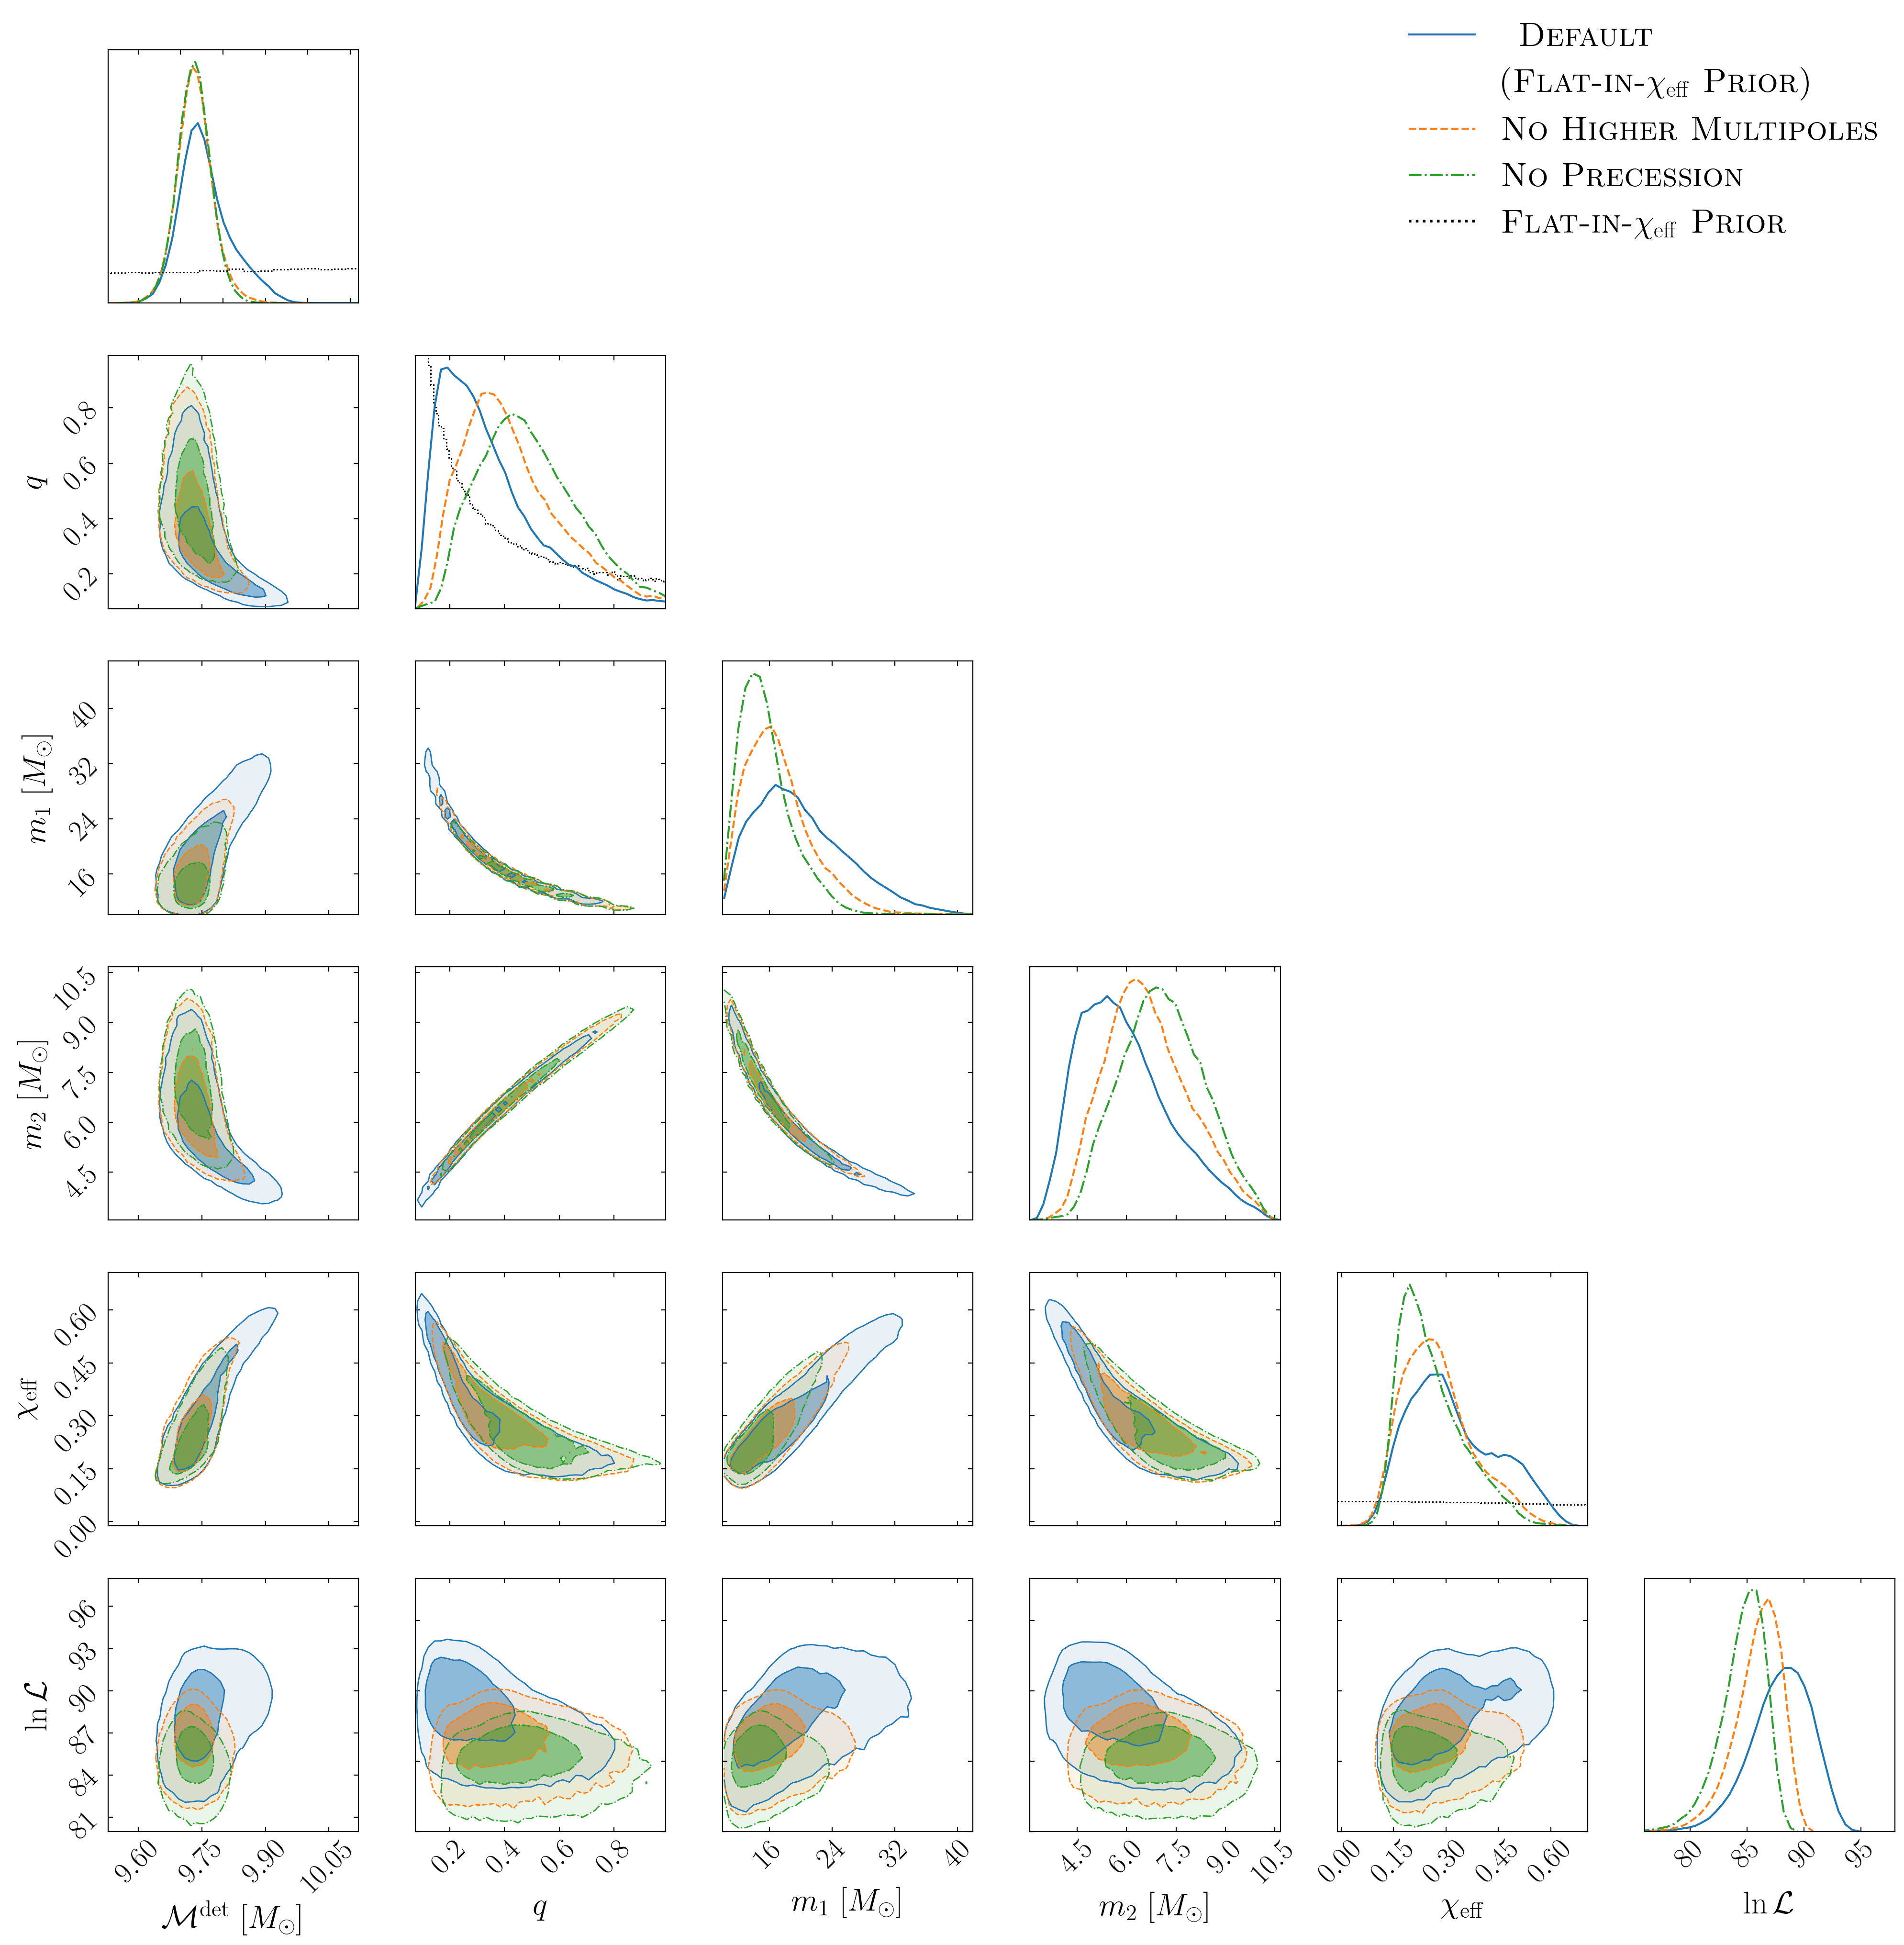

In [17]:
# Improve plot style

prior_style = plt.plot(np.arange(0,4), np.arange(0,4), color='black', linestyle='dotted', linewidth=2)

import matplotlib.font_manager as font_manager
font = font_manager.FontProperties(family='sans-serif', variant='small-caps', size=25)

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

_ = ax[2,2].set_xlim([10,42])
_ = ax[5,5].set_xlim([76,98])
_ = ax[5,0].set_ylim([80,98])

handles_1d, labels_1d = ax[0][0].get_legend_handles_labels()
handles_1d = handles_1d + prior_style
labels_1d.append(r'\textsc{Flat-in-$\chi_{\rm eff}$ Prior}')
fig.legends = []
fig.legend(handles_1d, labels_1d, loc='center right', bbox_to_anchor=(1,.95), frameon=False, prop=font)

labelsize=24;
labelpad=10;
labelpad2=2;
_ = ax[5,0].set_xlabel(r'$\mathcal{M}^{\rm det}$ $[M_\odot]$', fontsize=labelsize, labelpad=labelpad2)
_ = ax[5,1].set_xlabel(r'$q$', fontsize=labelsize, labelpad=labelpad)
_ = ax[5,2].set_xlabel(r'$m_1$ $[M_\odot]$', fontsize=labelsize, labelpad=labelpad)
_ = ax[5,3].set_xlabel(r'$m_2$ $[M_\odot]$', fontsize=labelsize, labelpad=labelpad2)
_ = ax[5,4].set_xlabel(r'$\chi_{\rm eff}$', fontsize=labelsize, labelpad=labelpad2)
_ = ax[5,5].set_xlabel(r'$\ln \mathcal{L}$', fontsize=labelsize, labelpad=labelpad+4)

_ = ax[1,0].set_ylabel(r'$q$', fontsize=labelsize, labelpad=labelpad)
_ = ax[2,0].set_ylabel(r'$m_1$ $[M_\odot]$', fontsize=labelsize, labelpad=labelpad)
_ = ax[3,0].set_ylabel(r'$m_2$ $[M_\odot]$', fontsize=labelsize, labelpad=labelpad2)
_ = ax[4,0].set_ylabel(r'$\chi_{\rm eff}$', fontsize=labelsize, labelpad=labelpad)
_ = ax[5,0].set_ylabel(r'$\ln \mathcal{L}$', fontsize=labelsize, labelpad=labelpad)

ticksize=22;

for i in [0,1,2,3,4,5]:
    _ = plt.setp(ax[5, i].get_xticklabels(), size=ticksize)

for i in [0,1,2,3,4,5]:
    _ = plt.setp(ax[i, 0].get_yticklabels(), size=ticksize)

plt.tight_layout()    

_ = ax[0,0].hist(ias_prior_samples[ias_prior_samples['mchirp']<10.2]['mchirp'], density=True, bins=20, histtype='step', facecolor='none', edgecolor='black', linestyle='dotted')
_ = ax[1,1].hist(ias_prior_samples['q'], density=True, bins=100, histtype='stepfilled', facecolor='none', edgecolor='black', linestyle='dotted')
_ = ax[4,4].hist(ias_prior_samples['chieff'], density=True, bins=20, histtype='stepfilled', facecolor='none', edgecolor='black', linestyle='dotted')
_ = ax[5,5].hist(ias_prior_samples['s1'], density=True, bins=20, histtype='stepfilled', facecolor='none', edgecolor='black', linestyle='dotted')

fig

## IAS vs LVC PE comparison

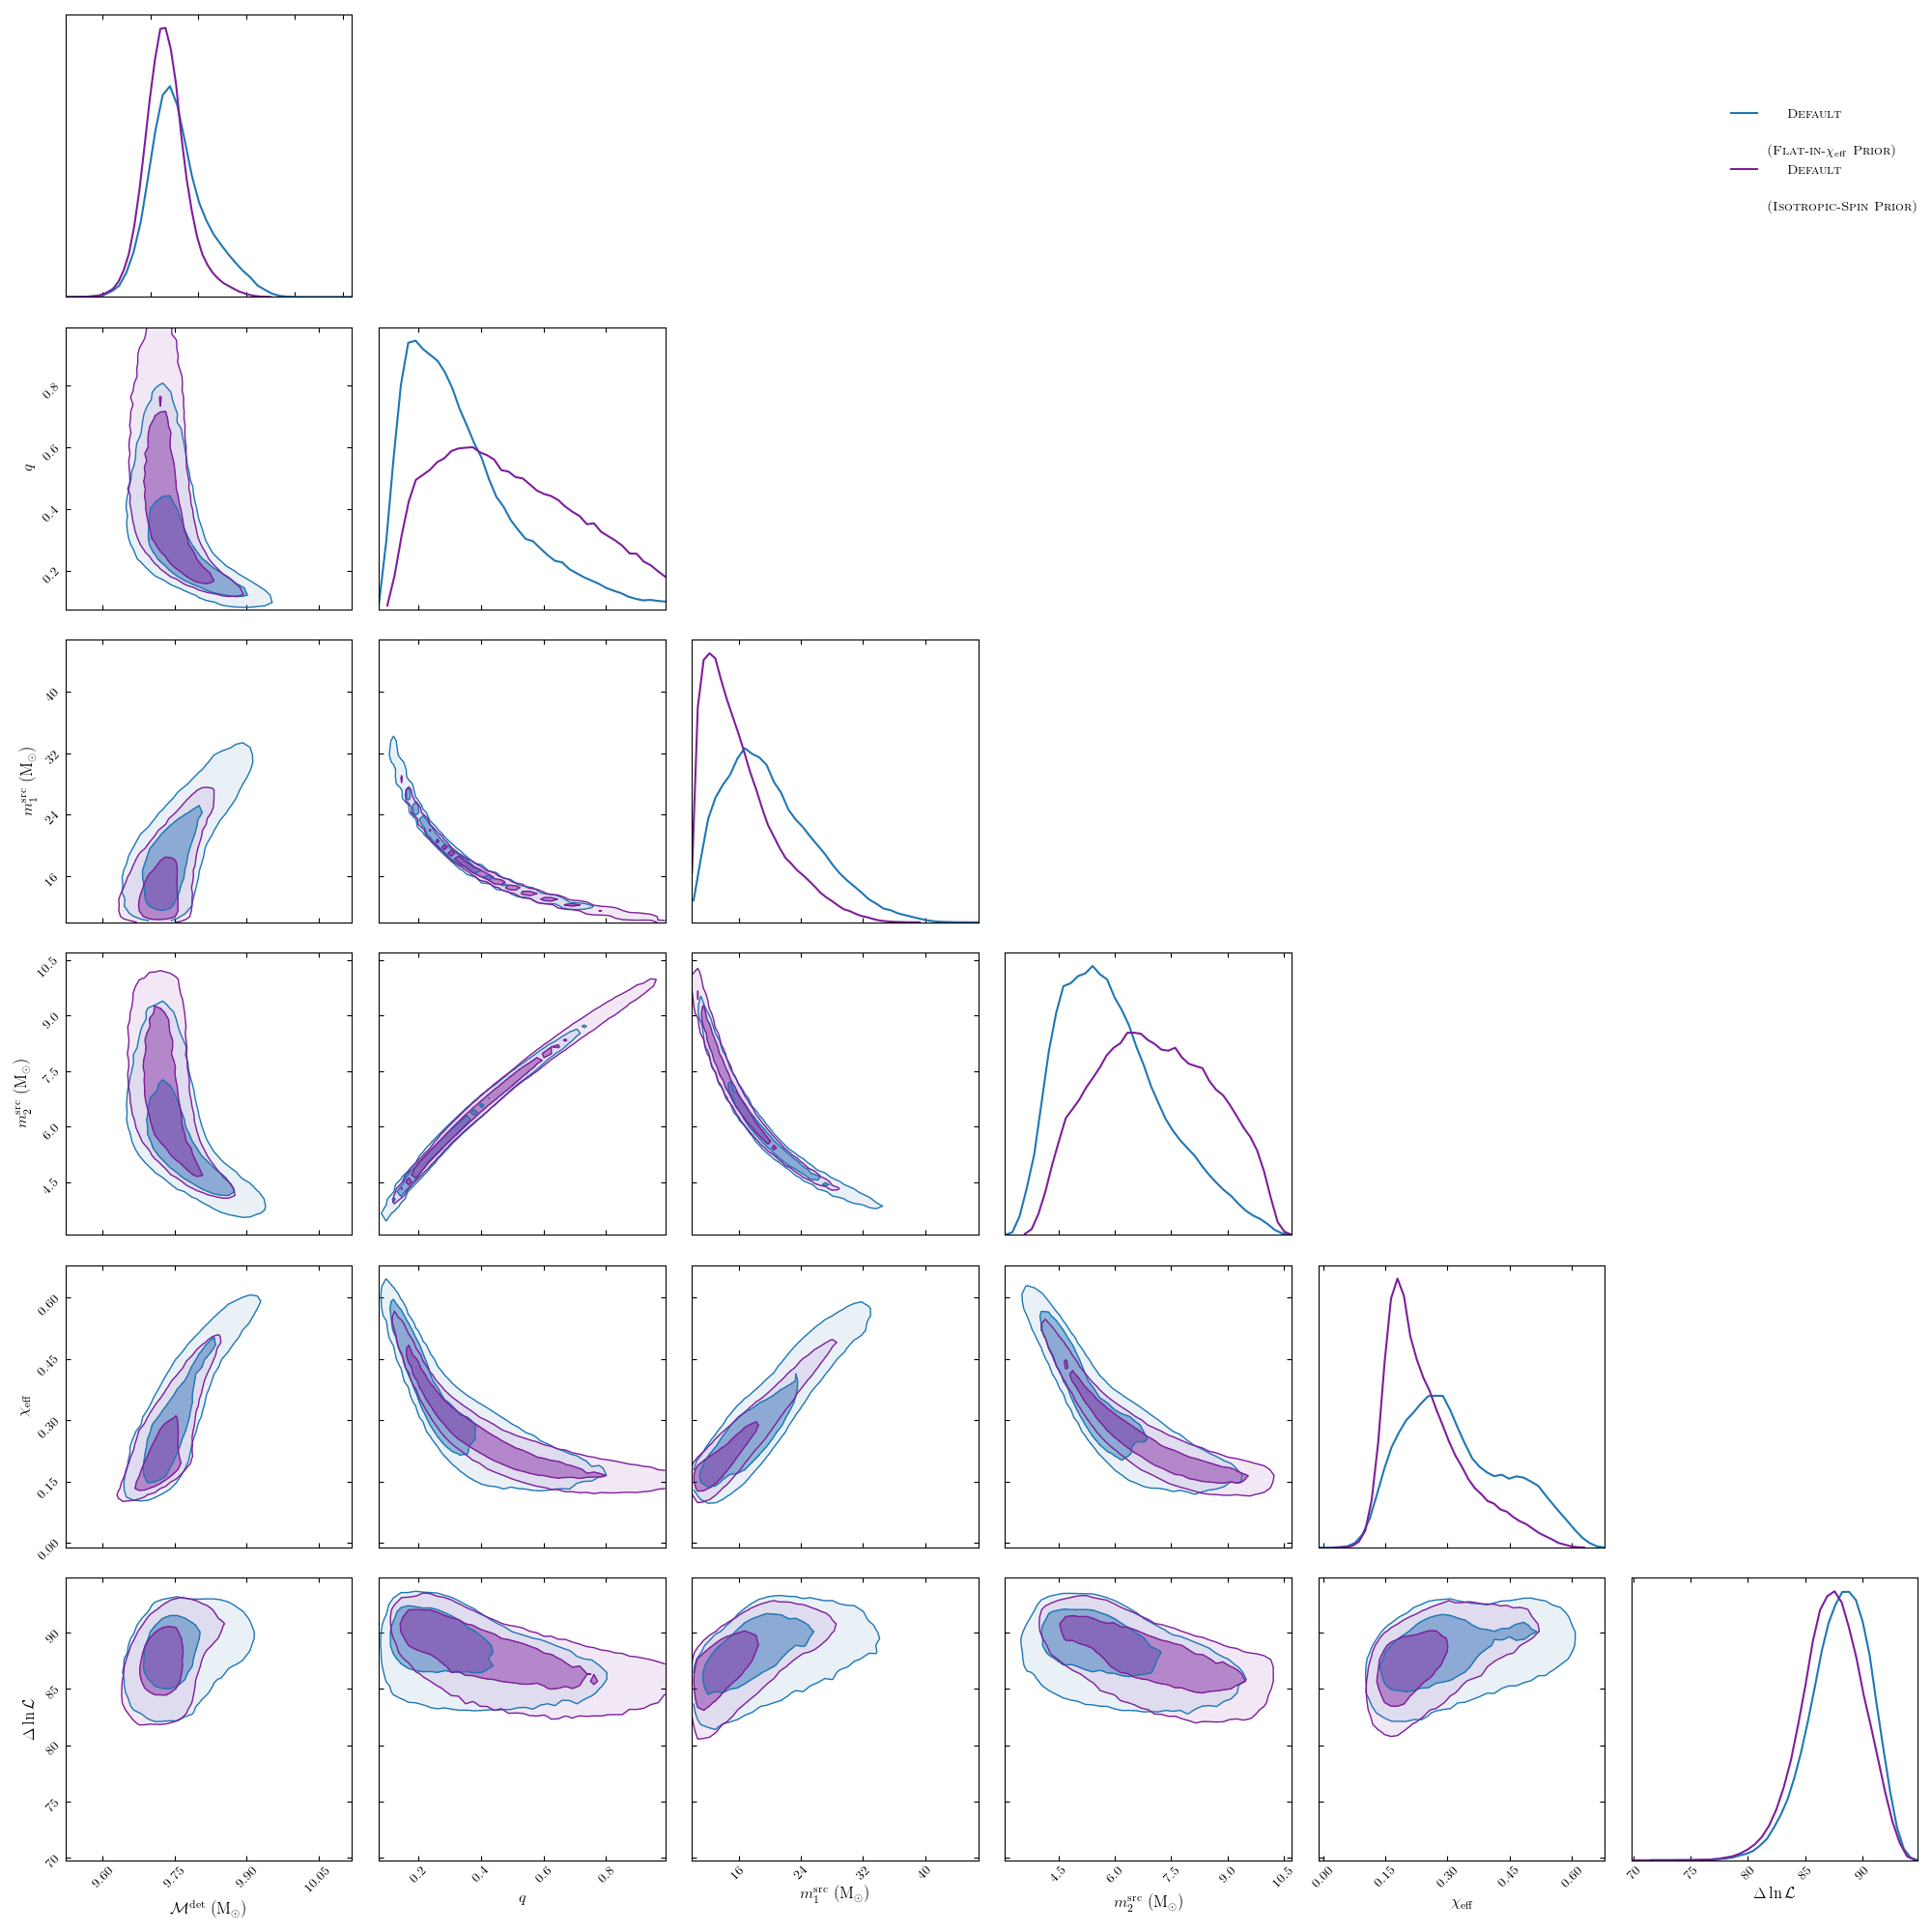

In [18]:
from matplotlib import rc
# #import matplotlib.pylab as plt
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

plot_linestyles = ['-', '-']
plot_colors = [COLORS[0], "#7E1E9C"]
fracs = [0.5, 0.9]

plot_plotstyles = []
for lsty, col in zip(plot_linestyles, plot_colors):
    plot_plotstyles.append(gd.PlotStyle(gd.PlotStyle1d(color=col, alpha_vlines=0, alpha_fill=0),
                                        gd.PlotStyle2d(color=col, linestyles=lsty, fractions=fracs, fill='flat')))
    
pe_names_lvc = [r"""\textsc{Default (Flat-in-$\chi_{\rm eff}$ Prior)}""", r'\textsc{Default (Isotropic-Spin Prior)}']

fig_lvc, ax_lvc = pe.corner_plot_comparison([pe_lvc], [r'\textsc{Default \\[15pt] (Isotropic-Spin Prior)}'],
                                              ['mchirp', 'q', 'm1_source', 'm2_source', 'chieff', 'lnl'], figsize=(20,20),
                                              multigrid_kwargs={'plotstyles': plot_plotstyles}
                                              #multigrid_kwargs={'linestyle':['-','-'], 'color':[gd.COLORS[0], '#7E1E9C']}
                                             )

In [20]:
# prior_ias_style = plt.plot(np.arange(0,4), np.arange(0,4), color=COLORS[0], linestyle='dotted', linewidth=2)
# prior_lvc_style = plt.plot(np.arange(0,4), np.arange(0,4), color='#7E1E9C', linestyle='dotted', linewidth=2)

# import matplotlib.font_manager as font_manager

# font = font_manager.FontProperties(family='sans-serif', variant='small-caps', size=25)

# from matplotlib import rcParams
# rcParams.update({'figure.autolayout': True})

# _ = ax_lvc[2,2].set_xlim([10,42])
# _ = ax_lvc[5,5].set_xlim([76,98])
# _ = ax_lvc[5,0].set_ylim([80,98])

# handles_1d_lvc, labels_1d_lvc = ax_lvc[0][0].get_legend_handles_labels()
# handles_1d_lvc = handles_1d_lvc + prior_ias_style + prior_lvc_style
# labels_1d_lvc.append(r'\textsc{Flat-in-$\chi_{\rm eff}$ Prior}')
# labels_1d_lvc.append(r'\textsc{Isotropic-Spin Prior}')
# fig_lvc.legends = []
# fig_lvc.legend(handles_1d_lvc, labels_1d_lvc, loc='center right', bbox_to_anchor=(1,.95), frameon=False, prop=font)

# labelsize=24;
# labelpad=10;
# labelpad2=2;
# _ = ax_lvc[5,0].set_xlabel(r'$\mathcal{M}^{\rm det}$ $[M_\odot]$', fontsize=labelsize, labelpad=labelpad2)
# _ = ax_lvc[5,1].set_xlabel(r'$q$', fontsize=labelsize, labelpad=labelpad)
# _ = ax_lvc[5,2].set_xlabel(r'$m_1$ $[M_\odot]$', fontsize=labelsize, labelpad=labelpad)
# _ = ax_lvc[5,3].set_xlabel(r'$m_2$ $[M_\odot]$', fontsize=labelsize, labelpad=labelpad2)
# _ = ax_lvc[5,4].set_xlabel(r'$\chi_{\rm eff}$', fontsize=labelsize, labelpad=labelpad2)
# _ = ax_lvc[5,5].set_xlabel(r'$\ln \mathcal{L}$', fontsize=labelsize, labelpad=labelpad+4)

# _ = ax_lvc[1,0].set_ylabel(r'$q$', fontsize=labelsize, labelpad=labelpad)
# _ = ax_lvc[2,0].set_ylabel(r'$m_1$ $[M_\odot]$', fontsize=labelsize, labelpad=labelpad)
# _ = ax_lvc[3,0].set_ylabel(r'$m_2$ $[M_\odot]$', fontsize=labelsize, labelpad=labelpad2)
# _ = ax_lvc[4,0].set_ylabel(r'$\chi_{\rm eff}$', fontsize=labelsize, labelpad=labelpad)
# _ = ax_lvc[5,0].set_ylabel(r'$\ln \mathcal{L}$', fontsize=labelsize, labelpad=labelpad)


# ticksize=22;

# for i in [0,1,2,3,4,5]:
#     _ = plt.setp(ax_lvc[5, i].get_xticklabels(), size=ticksize)

# for i in [0,1,2,3,4,5]:
#     _ = plt.setp(ax_lvc[i, 0].get_yticklabels(), size=ticksize)

# plt.tight_layout()   

# _ = ax_lvc[0,0].hist(ias_prior_samples[ias_prior_samples['mchirp']<10.2]['mchirp'], density=True, bins=20, histtype='step', facecolor='none', edgecolor=COLORS[0], linestyle='dotted', alpha=1, linewidth=2)
# _ = ax_lvc[1,1].hist(ias_prior_samples['q'], density=True, bins=100, histtype='stepfilled', facecolor='none', edgecolor=COLORS[0], linestyle='dotted', alpha=1, linewidth=2)
# _ = ax_lvc[4,4].hist(ias_prior_samples['chieff'], density=True, bins=100, histtype='stepfilled', facecolor='none', edgecolor=COLORS[0], linestyle='dotted', alpha=1, linewidth=2)

# _ = ax_lvc[0,0].hist(lvc_prior_samples[lvc_prior_samples['mchirp']<10.2]['mchirp'], density=True, bins=20, histtype='step', facecolor='none', edgecolor='#7E1E9C', linestyle='dotted', alpha=1, linewidth=2)
# _ = ax_lvc[1,1].hist(lvc_prior_samples['q'], density=True, bins=100, histtype='stepfilled', facecolor='none', edgecolor='#7E1E9C', linestyle='dotted', alpha=1, linewidth=2)
# _ = ax_lvc[4,4].hist(lvc_prior_samples['chieff'], density=True, bins=100, histtype='stepfilled', facecolor='none', edgecolor='#7E1E9C', linestyle='dotted', alpha=1, linewidth=2)

# fig_lvc

## Higher Modes Plot

In [21]:
sample_subset = pd.read_pickle('./sample_subset_22_included.pkl')
sample_subset_2233 = pd.read_pickle('./sample_subset_2233_included.pkl')

In [22]:
weights_22 = np.exp(sample_subset['lnl_22'] - sample_subset['lnl'])
weights_2233 = np.exp(sample_subset_2233['lnl_2233'] - sample_subset_2233['lnl'])
weights_223321 = np.exp(sample_subset['lnl_223321'] - sample_subset['lnl'])
weights_22213244 = np.exp(sample_subset['lnl_22213244'] - sample_subset['lnl'])

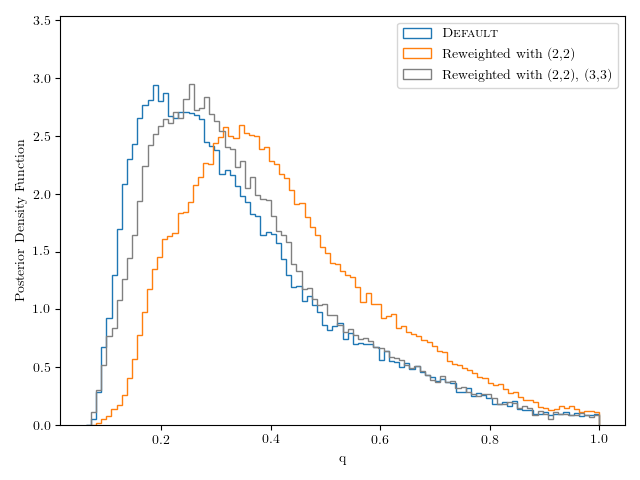

In [30]:
fig, ax = plt.subplots()
_ = plt.hist(sample_subset['q'], bins=100, density=True, histtype='step', label=r'\textsc{Default}')
_ = plt.hist(pe_noHM.samples['q'], bins=100, density=True, histtype='step', label=r'Reweighted with (2,2)')
_ = plt.hist(sample_subset_2233['q'], bins=100, weights=weights_2233, density=True, histtype='step', label=r'Reweighted with (2,2), (3,3)', color='gray')

_ = plt.xlabel('q')
_ = plt.ylabel('Posterior Density Function')
_ = plt.margins(x=None,y=0.2)
_ = plt.legend()

## In-plane-spin plot

In [61]:
# load spin angle variables

angle='cosiota'
angle_nopre = 'cosiota'

samp_default = pe.samples
samp_nohm = pe_noHM.samples
pe_nopre_finiteplanespin = pe_noPrec.samples

samp_default['s1x_sign'] = samp_default['s1x']*np.sign(samp_default[angle])
samp_default['s1y_sign'] = samp_default['s1y']*np.sign(samp_default[angle])
samp_nohm['s1x_sign'] = samp_nohm['s1x']*np.sign(samp_nohm[angle])
samp_nohm['s1y_sign'] = samp_nohm['s1y']*np.sign(samp_nohm[angle])
pe_nopre_finiteplanespin['s1x_sign'] = pe_nopre_finiteplanespin['s1x']*np.sign(pe_nopre_finiteplanespin[angle_nopre])
pe_nopre_finiteplanespin['s1y_sign'] = pe_nopre_finiteplanespin['s1y']*np.sign(pe_nopre_finiteplanespin[angle_nopre])

In [62]:
# sample from data file
Num=400000
samp_default_num = samp_default.iloc[np.random.choice(np.arange(len(pe.samples)), size=Num)]
samp_nohm_num = samp_nohm.iloc[np.random.choice(np.arange(len(pe_noHM.samples)), size=Num)]
pe_nopre_finiteplanespin_num = pe_nopre_finiteplanespin.iloc[np.random.choice(np.arange(len(pe_noPrec.samples)), size=Num)]

/home/hschia/PE/cogwheel/notebooks/../cogwheel/grid.py:365: UserWarning: No contour levels were found within the data range.
  contour = ax.contour(*[self[par] for par in self.params], self[pdf],


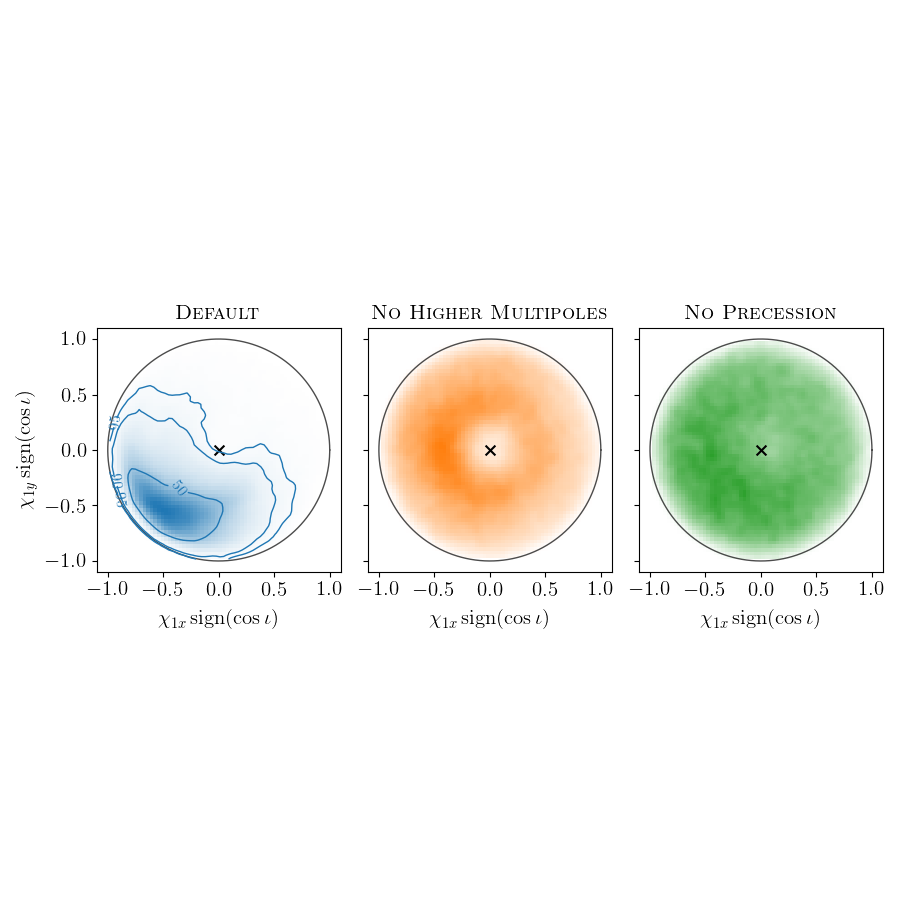

In [63]:
x = np.linspace(0, 2*np.pi, 300)

vmin=-1
vmax=1
labelsize=15
ticklabelsize=15
crossize=50
labelpad=6

fig, ax = plt.subplots(1,3, figsize=(9,9), sharey=True, sharex=True)

# ax[0].scatter(samp_default_num['s1x_sign'], samp_default_num['s1y_sign'], s=.8, lw=0, c=samp_default_num['q'])
_ = ax[0].plot(np.cos(x), np.sin(x), lw=1, c='k',linestyle='-', alpha=0.7)
_ = ax[0].scatter(0,0,marker='x', c='k', s=crossize)
_ = ax[0].set_title(r'\textsc{Default}', size=labelsize, pad=labelpad)

#ax[1].scatter(samp_nohm_num['s1x_sign'], samp_nohm_num['s1y_sign'], s=.8, lw=0, c=samp_nohm_num['q'])
_ = ax[1].plot(np.cos(x), np.sin(x), lw=1, c='k',linestyle='-', alpha=0.7)
_ = ax[1].scatter(0,0,marker='x', c='k', s=crossize)
_ = ax[1].set_title(r'\textsc{No Higher Multipoles}', size=labelsize, pad=labelpad)

#tmp = ax[2].scatter(pe_nopre_finiteplanespin_num['s1x_sign'], pe_nopre_finiteplanespin_num['s1y_sign'], s=.8, lw=0, c=pe_nopre_finiteplanespin_num['q'])
tmp = ax[2].plot(np.cos(x), np.sin(x), lw=1, c='k',linestyle='-', alpha=0.7)
tmp = ax[2].scatter(0,0,marker='x', c='k', s=crossize)
_ = ax[2].set_title(r'\textsc{No Precession}', size=labelsize, pad=labelpad)


bins=60
g = gd.Grid.from_samples(['s1x_sign', 's1y_sign'], samp_default, bins=bins)
g.gaussian_filter(1)


g2 = gd.Grid.from_samples(['s1x_sign', 's1y_sign'], samp_nohm, bins=bins)
g2.gaussian_filter()



g3 = gd.Grid.from_samples(['s1x_sign', 's1y_sign'], pe_nopre_finiteplanespin_num, bins=bins)
g3.gaussian_filter()

# Make 2d plot
g.grids_2d['s1x_sign', 's1y_sign'].plot_pdf('posterior', ax[0], style=plotstyle_2d)
g2.grids_2d['s1x_sign', 's1y_sign'].plot_pdf('posterior', ax[1], style=plotstyle_2d2)
g3.grids_2d['s1x_sign', 's1y_sign'].plot_pdf('posterior', ax[2], style=plotstyle_2d3)

leng = 1.1
_ = ax[0].set_xlim(-leng, leng)
_ = ax[1].set_xlim(-leng, leng)
_ = ax[2].set_xlim(-leng, leng)
_ = ax[0].set_ylim(-leng, leng)
_ = ax[1].set_ylim(-leng, leng)
_ = ax[2].set_ylim(-leng, leng)

_ = ax[0].set_aspect('equal')
_ = ax[1].set_aspect('equal')
_ = ax[2].set_aspect('equal')
#plt.grid()
_ = ax[0].set_xlabel(r'$\chi_{1x} \,$sign$(\cos \iota)$', size=labelsize, labelpad=labelpad)
_ = ax[1].set_xlabel(r'$\chi_{1x} \,$sign$(\cos \iota)$', size=labelsize, labelpad=labelpad)
_ = ax[2].set_xlabel(r'$\chi_{1x} \,$sign$(\cos \iota)$', size=labelsize, labelpad=labelpad)
_ = ax[0].set_ylabel(r'$\chi_{1y} \,$sign$(\cos \iota)$', size=labelsize, labelpad=labelpad)

tmp = ax[0].get_yticklabels()[1:-1:2]

_ = plt.setp(ax[0].get_yticklabels(), size=ticklabelsize)
_ = plt.setp(ax[0].get_xticklabels(), size=ticklabelsize)
_ = plt.setp(ax[1].get_xticklabels(), size=ticklabelsize)
_ = plt.setp(ax[2].get_xticklabels(), size=ticklabelsize)

_ = plt.subplots_adjust(wspace=50.4)
plt.tight_layout()

## Chi_p plot

Text(0.5, 0, '$\\chi_{p}$')

Text(0, 0.5, 'Posterior Density Function')

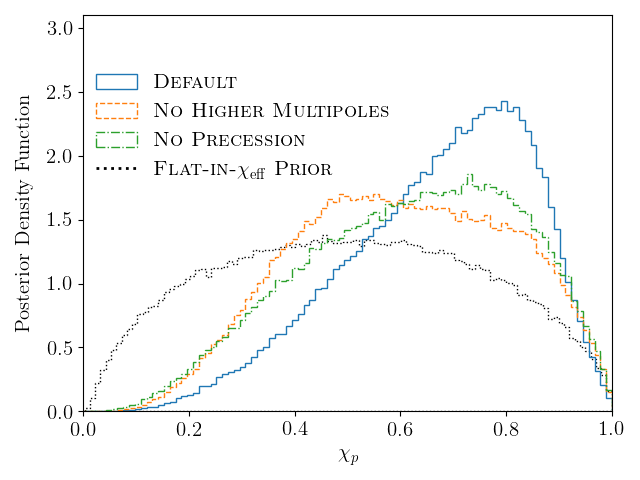

In [33]:
bins_chip = 100
highcolor='#B31B1B'

fig, ax = plt.subplots()
_ = plt.hist(pe.samples['chip'], density=True, bins=bins_chip, range=[-0.1, 1], histtype='step', label=r'\textsc{Default}')
_ = plt.hist(pe_noHM.samples['chip'], density=True, bins=bins_chip, range=[-0.1, 1], histtype='step', ls='--', label=r'\textsc{No Higher Multipoles}')
_ = plt.hist(pe_noPrec.samples['chip'], density=True, bins=bins_chip, range=[-0.1, 1], histtype='step', ls='-.', label=r'\textsc{No Precession}')

plt.xlabel(r'$\chi_{p}$')
plt.ylabel(r'Posterior Density Function')

import matplotlib.font_manager as font_manager

fontsize=15
fontsize_label=15
labelpad=5
labelpady=10
ticksize=15

font = font_manager.FontProperties(family='sans-serif', variant='small-caps', size=fontsize)

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

_ = ax.set_xlim([0,1])
_ = ax.set_ylim([0,3.1])

handles_1d, labels_1d = ax.get_legend_handles_labels()
handles_1d = handles_1d + prior_style
_ = labels_1d.append(r'\textsc{Flat-in-$\chi_{\rm eff}$ Prior}')
_ = fig.legends = []
_ = fig.legend(handles_1d, labels_1d, loc='upper left', bbox_to_anchor=(0.12,.885), frameon=False, prop=font)

_ = ax.set_xlabel('$\chi_{p}$', fontsize=fontsize_label, labelpad=labelpad)
_ = ax.set_ylabel('Posterior Density Function', fontsize=fontsize_label, labelpad=labelpady)
_ = plt.setp(ax.get_xticklabels(), size=ticksize)
_ = plt.setp(ax.get_yticklabels(), size=ticksize)
_ = ax.hist(ias_prior_samples['chip'], density=True, bins=100, histtype='stepfilled', facecolor='none', edgecolor='black', linestyle='dotted')


## Spin plot

In [34]:
plot_linestyles = ['-', '-']
plot_colors = [COLORS[0], "#7E1E9C"]
fracs = [0.5, 0.9]

plot_plotstyles = []
for lsty, col in zip(plot_linestyles, plot_colors):
    plot_plotstyles.append(gd.PlotStyle(gd.PlotStyle1d(color=col, alpha_vlines=0, alpha_fill=0),
                                        gd.PlotStyle2d(color=col, linestyles=lsty, fractions=fracs, fill='flat')))

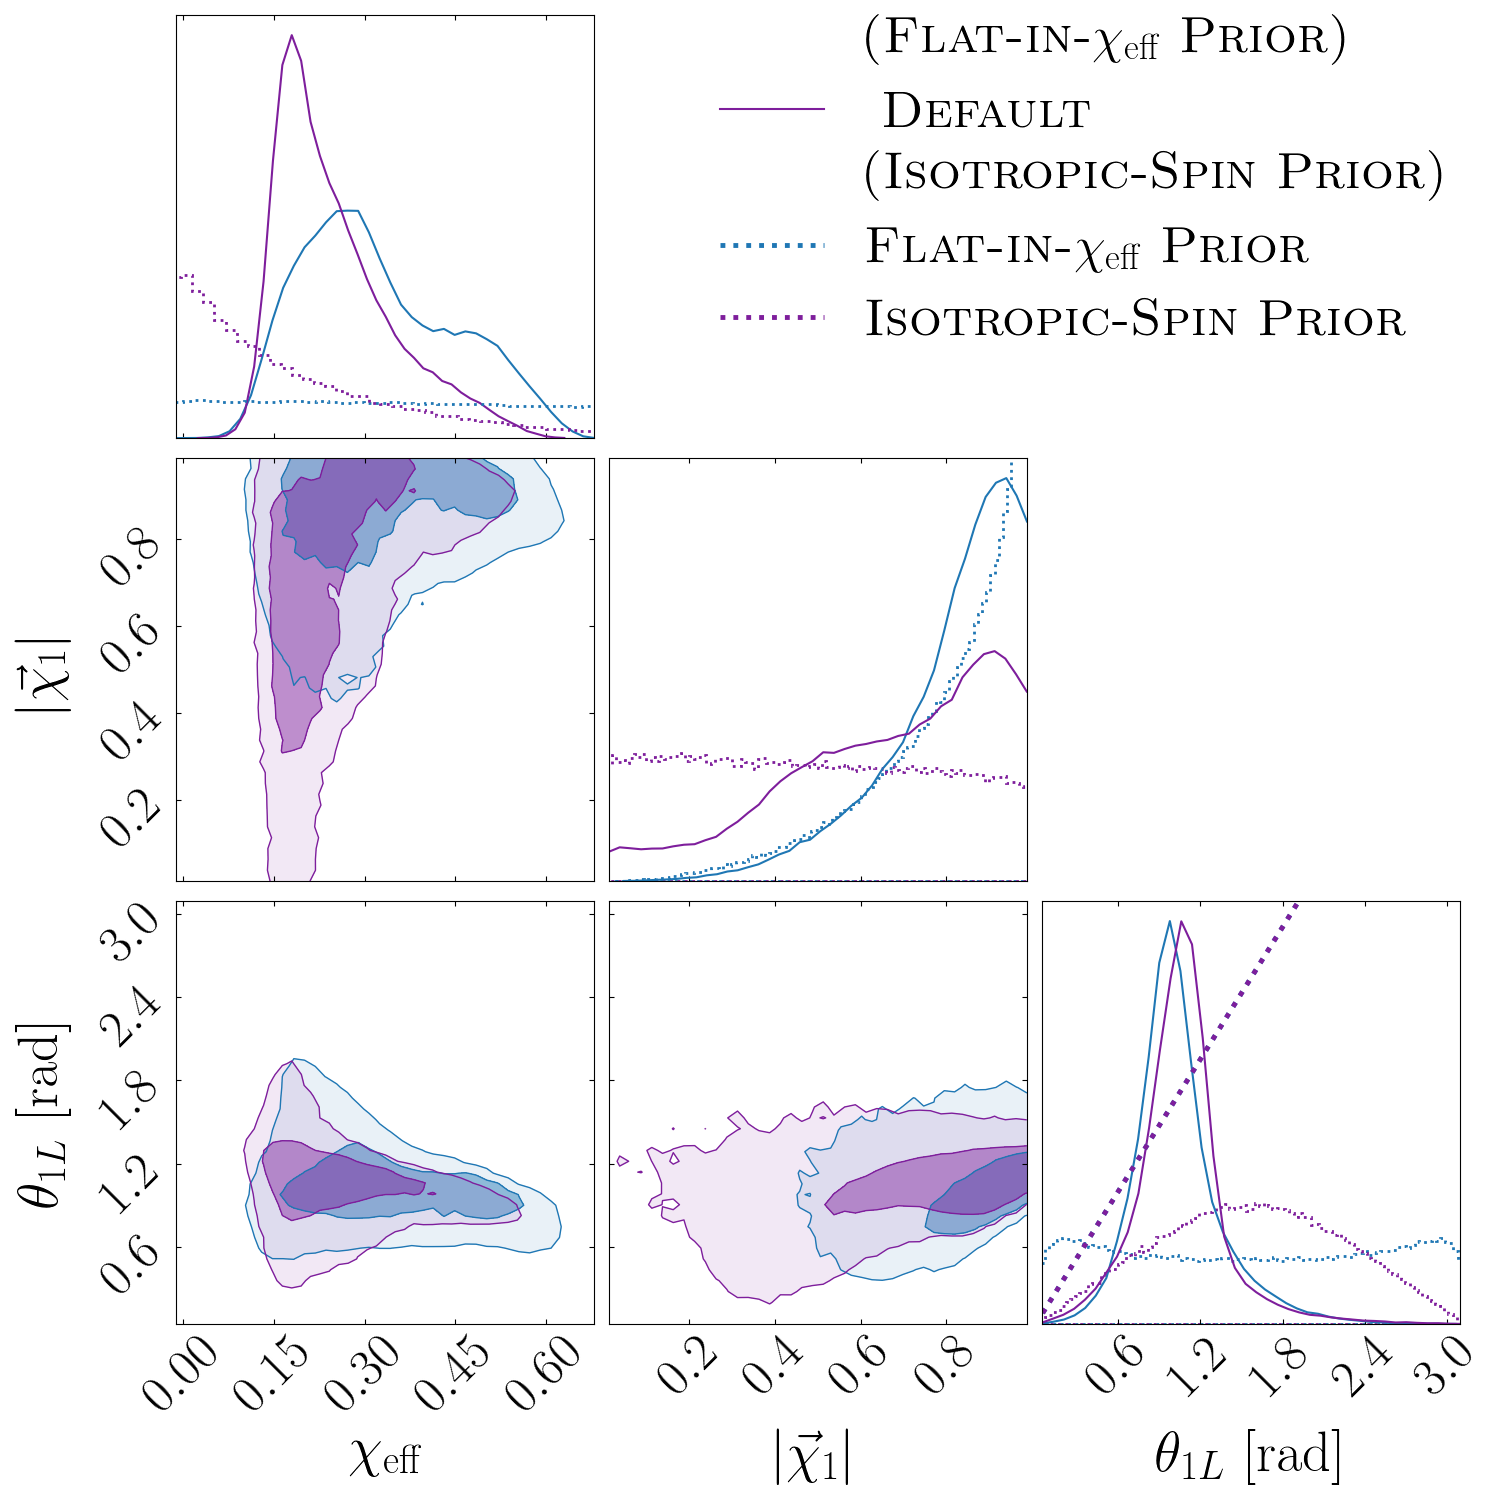

In [40]:
fig_spin, ax_spin = pe.corner_plot_comparison([pe_lvc], [r'\textsc{Default \\[15pt] (Isotropic-Spin Prior)}'],
                                              ['chieff', 's1', 's1theta'], figsize=(15,15),
                                              multigrid_kwargs={'plotstyles': plot_plotstyles}
                                              #multigrid_kwargs={'linestyle':['-','-'], 'color':[gd.COLORS[0], '#7E1E9C']}
                                             )

prior_ias_style = plt.plot(np.arange(0,4), np.arange(0,4), color=COLORS[0], linestyle='dotted', linewidth=3.5)
prior_lvc_style = plt.plot(np.arange(0,4), np.arange(0,4), color='#7E1E9C', linestyle='dotted', linewidth=3.5)

import matplotlib.font_manager as font_manager

fac=1.7;

font = font_manager.FontProperties(family='sans-serif', variant='small-caps', size=22*fac)

handles_1d_spin, labels_1d_spin = ax_spin[0][0].get_legend_handles_labels()
handles_1d_spin = handles_1d_spin + prior_ias_style + prior_lvc_style
_ = labels_1d_spin.append(r'\textsc{Flat-in-$\chi_{\rm eff}$ Prior}')
_ = labels_1d_spin.append(r'\textsc{Isotropic-Spin Prior}')
_ = fig_spin.legends = []
_ = fig_spin.legend(handles_1d_spin, labels_1d_spin, loc='center right', bbox_to_anchor=(1,.9), frameon=False, prop=font)

labelsize=24*fac;
labelpad=10*fac;
labelpad2=2*fac;

# ax_spin[0,0].annotate(r'high-$q$', xy=(0.22,4.5), xytext=(0.24,6.0),arrowprops=dict(arrowstyle="->",), fontsize=35)
# ax_spin[0,0].annotate(r'low-$q$', xy=(0.46,2.7), xytext=(0.39,4.2),arrowprops=dict(arrowstyle="->",), fontsize=35)

_ = ax_spin[2,0].set_xlabel(r'$\chi_{\rm eff}$', fontsize=labelsize, labelpad=labelpad2)
_ = ax_spin[2,1].set_xlabel(r'$|\vec{\chi}_1|$', fontsize=labelsize, labelpad=labelpad)
_ = ax_spin[2,2].set_xlabel(r'$\theta_{1L}$ [rad]', fontsize=labelsize, labelpad=labelpad)

_ = ax_spin[1,0].set_ylabel(r'$|\vec{\chi}_1|$', fontsize=labelsize, labelpad=labelpad)
_ = ax_spin[2,0].set_ylabel(r'$\theta_{1L}$ [rad]', fontsize=labelsize, labelpad=labelpad)

ticksize=22*fac;

for i in [0,1,2]:
    _ = plt.setp(ax_spin[2, i].get_xticklabels(), size=ticksize)

for i in [1,2]:
    _ = plt.setp(ax_spin[i, 0].get_yticklabels(), size=ticksize)

plt.tight_layout()    

_ = ax_spin[0,0].hist(ias_prior_samples['chieff'], density=True, bins=100, histtype='step', facecolor='none', edgecolor=COLORS[0], linestyle='dotted', alpha=1, linewidth=2)
_ = ax_spin[1,1].hist(ias_prior_samples['s1'], density=True, bins=100, histtype='stepfilled', facecolor='none', edgecolor=COLORS[0], linestyle='dotted', alpha=1, linewidth=2)
_ = ax_spin[2,2].hist(ias_prior_samples['s1theta'], density=True, bins=100, histtype='stepfilled', facecolor='none', edgecolor=COLORS[0], linestyle='dotted', alpha=1, linewidth=2)

_ = ax_spin[0,0].hist(lvc_prior_samples['chieff'], density=True, bins=100, histtype='step', facecolor='none', edgecolor='#7E1E9C', linestyle='dotted', alpha=1, linewidth=2)
_ = ax_spin[1,1].hist(lvc_prior_samples['s1'], density=True, bins=100, histtype='stepfilled', facecolor='none', edgecolor='#7E1E9C', linestyle='dotted', alpha=1, linewidth=2)
_ = ax_spin[2,2].hist(lvc_prior_samples['s1theta'], density=True, bins=100, histtype='stepfilled', facecolor='none', edgecolor='#7E1E9C', linestyle='dotted', alpha=1, linewidth=2)